In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy
import re
import jieba

In [2]:
corpus =["今天天气很好,","今天上NLP课程","NLP是目前最火的方向"]
#text = list(jieba.cut(text))
re_han, re_skip = re.compile(r"([\u4E00-\u9FA5]+)"), re.compile(r"[^a-zA-Z0-9+#\n]")
(re_han.split(''.join(corpus)),re_skip.split(''.join(corpus)))

(['', '今天天气很好', ',', '今天上', 'NLP', '课程', 'NLP', '是目前最火的方向', ''],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'NLP',
  '',
  'NLP',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [3]:
def connect(corpus):
    text_list= []
    for sentence in corpus:
        text_list+=list(jieba.cut(sentence))
    return np.array(text_list)
text = connect(corpus)
text

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/sl/q8x6_03132dfk7rktf00yh880000gn/T/jieba.cache
Loading model cost 0.760 seconds.
Prefix dict has been built successfully.


array(['今天天气', '很', '好', ',', '今天', '上', 'NLP', '课程', 'NLP', '是', '目前',
       '最火', '的', '方向'], dtype='<U4')

In [4]:
def encoder(sentence_list):
    unique , counter = np.unique(sentence_list,return_counts=True)
    range_ = np.arange(unique.size)
    encode_dict = dict(zip(unique,range_))
    decode_dist = dict(zip(range_,unique))
    code_sentence =  torch.Tensor([encode_dict[word] for word in sentence_list])
    return code_sentence,encode_dict,decode_dist
code_sentence,encode_dict,decode_dist = encoder(text)
code_sentence,encode_dict, decode_dist

(tensor([ 4.,  6.,  5.,  0.,  3.,  2.,  1., 12.,  1.,  8., 11.,  9., 10.,  7.]),
 {',': 0,
  'NLP': 1,
  '上': 2,
  '今天': 3,
  '今天天气': 4,
  '好': 5,
  '很': 6,
  '方向': 7,
  '是': 8,
  '最火': 9,
  '的': 10,
  '目前': 11,
  '课程': 12},
 {0: ',',
  1: 'NLP',
  2: '上',
  3: '今天',
  4: '今天天气',
  5: '好',
  6: '很',
  7: '方向',
  8: '是',
  9: '最火',
  10: '的',
  11: '目前',
  12: '课程'})

In [5]:
def smooth_words(sentence,n=5):
    unique = np.unique(text)
    u , v = dict() , dict()
    for word in unique:
        index_ = np.ravel(np.argwhere(sentence == word))
        point_word = sentence[index_]
        temp_u = {point_word[0]:index_}
        u.update(temp_u)
    return u
smooth_words(text)

{',': array([3]),
 'NLP': array([6, 8]),
 '上': array([5]),
 '今天': array([4]),
 '今天天气': array([0]),
 '好': array([2]),
 '很': array([1]),
 '方向': array([13]),
 '是': array([9]),
 '最火': array([11]),
 '的': array([12]),
 '目前': array([10]),
 '课程': array([7])}

In [6]:
def jump_words(sentence):
    m = int(len(sentence)/2)
    point_word = sentence[m]
    return torch.Tensor([[word,point_word] for word in sentence if word != point_word])
jump_words(code_sentence)

tensor([[ 4., 12.],
        [ 6., 12.],
        [ 5., 12.],
        [ 0., 12.],
        [ 3., 12.],
        [ 2., 12.],
        [ 1., 12.],
        [ 1., 12.],
        [ 8., 12.],
        [11., 12.],
        [ 9., 12.],
        [10., 12.],
        [ 7., 12.]])

## u是上下文词的概率矩阵 v是中心词的概率矩阵

## $$P(c|w;\theta) = {\frac{ e^{u_{c}}.v_{w} }{ \sum{e^u{c^{'}.v_{w}}} } }$$

## $ P(c|w;\theta)$ 目标是当c 与 w 越近的时候 $ \theta $ 越大越好 
## $ u^{c} 是背景词 v_{w} 是中心词 $
## $ {u_{c}}.v_{w} 的意思是:u 矩阵 和v矩阵当中，当单词分别为 c，w时 c，w的词向量内积$
## $ e 是自然常数,为单调递增指数 作为底数的时候则将条件概率假定为伯努利分布映射到整个概率空间当中，求导不变 $ 
## $ e^{n} $ 
## $ c^{'} 的意思是整个词库里的所有单词 $
## $ {c^{'}.v_{w}} 是用所有单词乘上v_{w}$
## 注意：向量内积其实本质是向量的相似度


# $$ src : argmax_{\theta} \sum_{w \in Text}{\sum_{c \in context(w)}{P(c|w;\theta)}} $$
## $ 因为 :{P(c|w;\theta)} =  {\frac{ e^{u_{c}}.v_{w} }{ \sum{e^u{c^{'}.v_{w}}} } } $
## $ 所以 : argmax {\sum_{w \in Text}{\sum_{c \in context(w)}}\frac{ e^{u_{c}}.v_{w} }{ \sum{e^u{c^{'}.v_{w}}} } }$
## $ 约掉e 则得到 $
## $ argmax \sum_{w \in Text}{\sum_{c \in context(w)}[u_{c}.v_{w} -log(\sum{e^{u_{c^{' \in words}}-v_{w}}})]} $ 

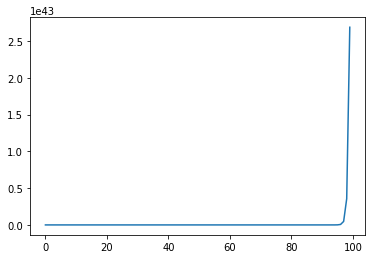

In [9]:
plt.plot(np.exp(np.linspace(-100,100,100)))